# Learning goals
After today's lesson you should be able to:
- Get Census data from the U.S. Census API
- Use the Socrata API


Some of today's lessons borrow from: 
- [PyGIS - Open Source Spatial Programming and Remote Sensing book](https://pygis.io/docs/d_access_census.html)
- [The Socrata SODA API documentation](https://dev.socrata.com/consumers/getting-started.html)

In [ ]:
## You might need to run these or manually add the libraries to your environment in Anaconda
# !pip install census
# !pip install us

In [2]:
# We are going to start importing the libraries we need
# all in one cell. 
# It is a good practice to keep all the imports in one cell so that
# we can easily see what libraries we are using in the notebook.
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

## The set_context() function is really useful!
## It allows us to set the size of the fonts in our plots based on whether 
## we are making a poster, a talk, a notebook, etc.

## If you are only presenting these figures in your jupyter notebook, 
## there is no need to set the context to be "talk" or "poster"
## But, I sometimes set my context to be "talk" or "poster" even for articles
## because I like the fonts to be bigger.
sns.set_context(context='paper')

# we use the inline backend to generate the plots within the browser
%matplotlib inline

from census import Census
from us import states



# 0. Census Data: Census survey and statistical boundaries

## 0.1 Census Surveys
The United States Census Bureau has been collecting information on its residents in the country since 1780 through surveys sent by mail (since 2020, you can submit your survey by phone, mail, or online). Census data is used for a variety of governmental purposes including: provision of housing, infrastructure, and public amenities; making districting decisions for schools, precints, and elections; and more generally, to understand the population, socio-economic, and demographic characteristics of residents in the country. [Did you know that the punch card machine (a prototype for the computer) was created for the 1890 Census?](https://en.wikipedia.org/wiki/Tabulating_machine)

The US Census has historically been taken every 10 years. Every household in the U.S. is sent a Census survey (and you are legally required to respond.) In 2005, the Census Bureau created the American Community Survey (ACS), which is collected every month on a sample of households.

Since 2020, the Census only contains 10 questions (historically called the "short form census") such as age, sex, race, Hispanic origin, and owner/renter status. The ACS contains a larger set of questions such as employment, education, transportation.

Because the ACS is more frequent, it is often used for more current census needs; however, because it is also a sample, we generally need a longer time span to get a robust sample. This is why we will often use the **5-yr ACS** (for ex: 2012 - 2016 ACS) to represent the year (here, 2014).

Census data is often the baseline survey dataset in the area of urban planning because it provides racial, socio-economic, housing, etc. information that is often the highlight or backdrop of a study.

## 0.2 Census Geographies
There are different, often nested Census geographic regions used for  different administrative scales. The most commonly used regions are statistical areas, typically nested within each other, whose boundaries are defined by certain physical, administrative, and population constraints. For instance, a **Census block** is bounded by physical features such as streets and administrative boundaries such as city limits and school districts. **Block groups**, the smallest unit of analysis that is still mostly statistically robust, are collections of Census blocks (hence the name) that generally have between 800 to 5000 people. **Census tracts** generally have between 1000 and 8000 people. [Here's more information](https://pitt.libguides.com/uscensus/understandinggeography) about Census geographies if you're curious.

See the image below for how these regions nest within one another.

</figure>
<img src="https://www.dropbox.com/s/8w69pibhwffgoc0/qgis_censusgeography.png?dl=1" alt="drawing" width="500" style="display: block; margin: 0 auto"/>
</figure>


## 0.3 [Social Explorer](https://www-socialexplorer-com.proxy.library.cornell.edu/ezproxy)
This is a great tool for looking at Census and ACS data visually. They also have datasets beyond just Census Bureau data. You can also output images and shareable links to the map. I encourage you to sign up (through Cornell it's free) and explore this tool on your own time.


## 0.4 What is an API 
APIs are tools that allow different software applications to communicate with one another. In particular, the Census API allows us to access data from the US Census Bureau.

# 1. U.S. Census 
The Census makes data publicly available directly from their website `census.gov`. They have a bunch of APIs on their website that allow you to access various datasets: 
</figure>
<img src="https://www.dropbox.com/scl/fi/glfgqu8evzpqql70eq08w/Screen-Shot-2024-02-11-at-11.27.10-AM.png?rlkey=e6gio2bjp7w1eadjf2v3tecp2&dl=1" alt="drawing" width="1000" style="display: block; margin: 0 auto"/>
</figure>


## 1.1 Census Python Package
The `census` python library is a wrapper for the US Census API. We are also going to use a helper tool called `us` that helps us to navigate the FIPS codes and other US State metadata like capitals, time zones, postal codes, etc. 


In [3]:
states.VA.fips

'51'

In [4]:
states.NY.fips

'36'

In [5]:
states.NY.capital

'Albany'

You will need to create and keep track of your Census API key, which can be obtained [here](http://api.census.gov/data/key_signup.html)

In [ ]:
# Set API key
c = Census("YOUR CENSUS API KEY HERE")


In [6]:
c = Census("d9c002dc1334c8f6cbea48d3f10a4176cdf89064")


## 1.2 Getting the ACS 5-year
There are various geographies at which we can get the ACS 5-year tables, here are the functions and inputs: 

* state(fields, state_fips)
* state_county(fields, state_fips, county_fips)
* state_county_blockgroup(fields, state_fips, county_fips, blockgroup)
* state_county_subdivision(fields, state_fips, county_fips, subdiv_fips)
* state_county_tract(fields, state_fips, county_fips, tract)
* state_place(fields, state_fips, place)
* state_congressional_district(fields, state_fips, congressional_district)
* state_legislative_district_upper(fields, state_fips, legislative_district)
* state_legislative_district_lower(fields, state_fips, legislative_district)
* us(fields)
* state_zipcode(fields, state_fips, zip5)

You can consult the [documentation](https://pypi.org/project/census/) to see which vintages the library has. It looks like they only have up to the 2021 5YR (2017-2021). 


Going on the [ACS 5Yr page on the census website](https://www.census.gov/data/developers/data-sets/acs-5year.html) (make sure to select the correct year!), we can see the different types of tables that exist. 

We are interested in columns from the "[Detailed Tables](https://api.census.gov/data/2021/acs/acs5/variables.html)" here. 


We can also use the [Table Shells and Table List](https://www.census.gov/programs-surveys/acs/technical-documentation/table-shells.2021.html#list-tab-79594641) to more quickly look for the columns we need. "The ACS table list contains columns with the table IDs, table titles, table universes, and 1-year/5-year availability for all Detailed Tables, Supplemental Estimate Tables, Comparison Profiles, Data Profiles, and Subject Tables in one spreadsheet."

You will have to download the `XXXX ACS Detailed Table Shells` for the ACS 1/5 YR if you want to use the table shells. 

</figure>
<img src="https://www.dropbox.com/scl/fi/gx1q7o27byz9lt83o6ekr/Screen-Shot-2024-02-12-at-11.17.28-AM.png?rlkey=s4y1r0gathbpnu0vqs4z4zrtf&dl=1" alt="drawing" width="1000" style="display: block; margin: 0 auto"/>
</figure>

In [7]:
# B16010_041E: is the total number of people with an educational attainment of a bachelor's degree or higher
# B01003_001E: total population
ny_census = c.acs5.state_county_tract(fields = ('NAME', 'B16010_041E','B01003_001E'),
                                      state_fips = states.NY.fips,
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2019)

We do need to create a `GEOID` column that's the actual FIPS code. 

In [9]:
# ny_census

In [10]:
ny_df = pd.DataFrame(ny_census)

In [11]:
ny_df

,NAME,B16010_041E,B01003_001E,state,county,tract
0,"Census Tract 55, Onondaga County, New York",825.0,3563.0,36,067,005500
1,"Census Tract 56.01, Onondaga County, New York",730.0,1599.0,36,067,005601
2,"Census Tract 61.02, Onondaga County, New York",526.0,1842.0,36,067,006102
3,"Census Tract 112.01, Onondaga County, New York",680.0,3844.0,36,067,011201
4,"Census Tract 56.02, Onondaga County, New York",65.0,3950.0,36,067,005602
...,...,...,...,...,...,...
4913,"Census Tract 18, Onondaga County, New York",682.0,3048.0,36,067,001800
4914,"Census Tract 34, Onondaga County, New York",313.0,1393.0,36,067,003400
4915,"Census Tract 40, Onondaga County, New York",53.0,1387.0,36,067,004000
4916,"Census Tract 48, Onondaga County, New York",690.0,1541.0,36,067,004800


In [12]:
ny_df["GEOID"] = ny_df["state"] + ny_df["county"] + ny_df["tract"]


In [14]:
ny_df.head()

,NAME,B16010_041E,B01003_001E,state,county,tract,GEOID
0,"Census Tract 55, Onondaga County, New York",825.0,3563.0,36,067,005500,36067005500
1,"Census Tract 56.01, Onondaga County, New York",730.0,1599.0,36,067,005601,36067005601
2,"Census Tract 61.02, Onondaga County, New York",526.0,1842.0,36,067,006102,36067006102
3,"Census Tract 112.01, Onondaga County, New York",680.0,3844.0,36,067,011201,36067011201
4,"Census Tract 56.02, Onondaga County, New York",65.0,3950.0,36,067,005602,36067005602


In [15]:
ny_df.shape

(4918, 7)

We can also translate the number of people with a college degree or higher to a percentage

In [16]:
ny_df['college_ed_perc'] = ny_df['B16010_041E'] / ny_df['B01003_001E'] 

In [17]:
ny_df.head()

,NAME,B16010_041E,B01003_001E,state,county,tract,GEOID,college_ed_perc
0,"Census Tract 55, Onondaga County, New York",825.0,3563.0,36,067,005500,36067005500,0.231546
1,"Census Tract 56.01, Onondaga County, New York",730.0,1599.0,36,067,005601,36067005601,0.456535
2,"Census Tract 61.02, Onondaga County, New York",526.0,1842.0,36,067,006102,36067006102,0.285559
3,"Census Tract 112.01, Onondaga County, New York",680.0,3844.0,36,067,011201,36067011201,0.176899
4,"Census Tract 56.02, Onondaga County, New York",65.0,3950.0,36,067,005602,36067005602,0.016456


## 1.3 Get the shapefiles 
The Census also maintains a [set of shapefiles](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html) that has the geometries by state, counties, tracts, block groups, and more. 

When you go to the Tiger/Line Shapefiles, make sure to select the year you are looking for: 
</figure>
<img src="https://www.dropbox.com/scl/fi/qbbj4x6jer4sjtldb228u/Screen-Shot-2024-02-12-at-10.29.16-AM.png?rlkey=i6t2k6zr8e83ofy4rjh58pou8&dl=1" alt="drawing" width="1000" style="display: block; margin: 0 auto"/>
</figure>

You can use the **FTP Archive** to find the particular boundary and state you need (you'll have to know the FIPS code for the state):

</figure>
<img src="https://www.dropbox.com/scl/fi/wj3ewuazhzx84c5bbtnjm/Screen-Shot-2024-02-12-at-10.40.24-AM.png?rlkey=zxresvebgfods8p69yjqolde4&dl=1" alt="drawing" width="1000" style="display: block; margin: 0 auto"/>
</figure>


Once you have all this information, you can read the shapefile directly from the URL link: 

In [18]:
ny_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_36_tract.zip")


In [19]:
ny_tract.shape

(4918, 13)

In [20]:
ny_tract.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,36,081,044800,36081044800,448,Census Tract 448,G5020,S,208002,0,+40.7110219,-073.8026344,"POLYGON ((-73.80646 40.71206, -73.80556 40.712..."
1,36,081,045800,36081045800,458,Census Tract 458,G5020,S,245281,0,+40.7152626,-073.7909261,"POLYGON ((-73.79364 40.71382, -73.79362 40.713..."
2,36,081,046200,36081046200,462,Census Tract 462,G5020,S,249611,0,+40.7098547,-073.7879749,"POLYGON ((-73.79203 40.71107, -73.79101 40.711..."
3,36,081,046300,36081046300,463,Census Tract 463,G5020,S,159415,0,+40.7440007,-073.8710900,"POLYGON ((-73.87468 40.74335, -73.87423 40.743..."
4,36,081,046400,36081046400,464,Census Tract 464,G5020,S,228767,0,+40.7168637,-073.7869958,"POLYGON ((-73.79187 40.71379, -73.79085 40.714..."


Finally, we can merge the tables we created with the shapefile

In [21]:
ny_census_geo = ny_tract.merge(ny_df, left_on = 'GEOID', right_on = 'GEOID')

In [22]:
ny_census_geo.shape

(4918, 20)

<AxesSubplot: >

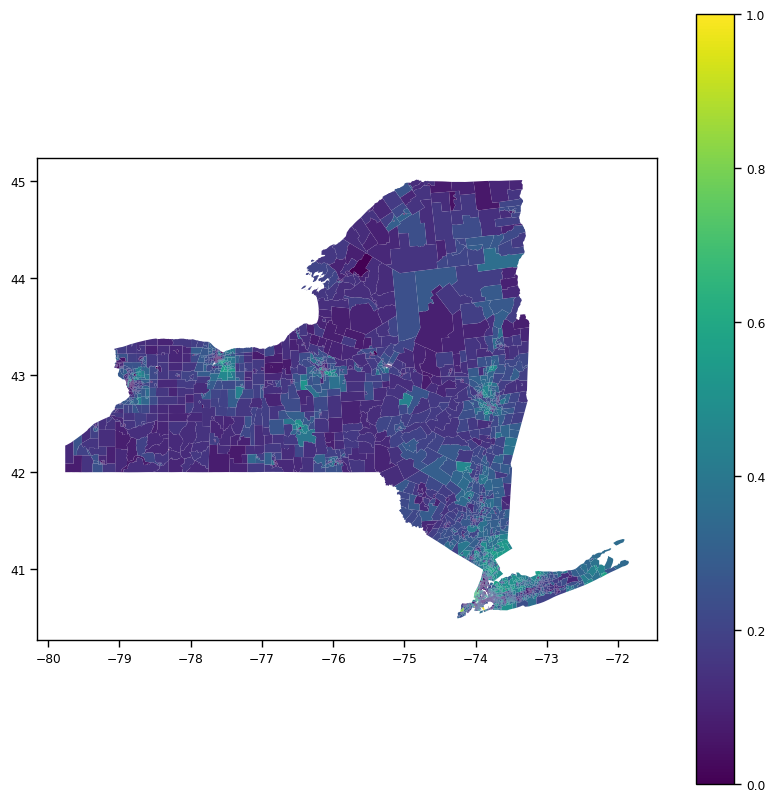

In [23]:
ny_census_geo.plot('college_ed_perc', legend = True, figsize = (10,10))

## Q.1
List at least one reason why the above is not a clear figure in a markdown cell. 

INSERT YOUR TEXT HERE.

## Q.2 
Using the [ACS table](https://www.census.gov/programs-surveys/acs/technical-documentation/table-shells.2019.html#list-tab-LO1F1MU1CQP3YOHD2T) lookup page to download "2019 ACS Detailed Table Shells"
- Find the table ID (in the format of "B00000") for the **HISPANIC OR LATINO ORIGIN BY RACE** table 
- Plot the percentage Hispanic or Latino Origin by Race for Oregon using the method we described above. 


In [ ]:
### INSERT YOUR CODE HERE
or_census_geo = 

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))

or_census_geo.plot(### INSERT YOUR CODE HERE)
ax.set_axis_off()

## Use tight_layout to remove the white space around the plot
plt.tight_layout()

## I forgot to show you all how to save down your plots!
fig.savefig('OR_perc_hispanic.png')   # save the figure to file

## 2. Socrata and Socrata APIs
Many government open data portals were built by the same company, Socrata (acquired a few years back by Tyler Technologies), which created the infrastructure and front-end interface to access open government data. 

We are going to look at Mandatory Inclusionary Housing zones in New York City [here](https://data.cityofnewyork.us/Housing-Development/Mandatory-Inclusionary-Housing-MIH-/bw8v-wzdr).


You may have noticed that, when we go to export data, that there is a **SODA API** section: 
</figure>
<img src="https://www.dropbox.com/s/0ewtgsg8lc4sl3j/Screen%20Shot%202024-02-12%20at%2011.30.04%20AM.png?dl=1" alt="drawing" width="1000" style="display: block; margin: 0 auto"/>
</figure>

SODA is Socrata's API for allowing users from researchers to (more often) people building tools and applications to access open-portal data. This is most useful when you have to programmatically connect your data export to something else. For instance, if you're running a website that needs to update data in real-time or if you don't want to download an updated dataset each time, you can connect your notebook or app to this API. Click to expand the **SODA API** section.


**Copy the API endpoint URL**. 

## 2.1 API endpoint to GeoDataFrame

We can pretty easily this JSON file into a geodataframe. FYI, a JSON stands for "JavaScript Object Notation" and is a file format that was desisgned for the JavaScript language, but is easily translated to other formats that we know well. 

The good thing is that pandas has a `pd.read_json()` function that will allow us read this JSON as a DF and eventually turn it into a geodataframe. 

In [24]:
# mih = pd.read_json('https://data.cityofnewyork.us/resource/m79g-k9r4.json')
mih = pd.read_json('https://data.cityofnewyork.us/resource/m79g-k9r4.json')



In [25]:
mih.head()

,the_geom,boro,status,project_nam,date_adopte,zr_ulurpno,zr_map,cd,mih_option,zoning_map,project_id,shape_leng,shape_le_1,shape_le_2,shape_area
0,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",3,Adopted,587 Bergen Street Rezoning,2018-01-31T00:00:00.000,170357ZRK,CD8-Map 2 (Area 1),8,Option 1,16c,P2014K0056,994.864292,994.864292,994.864292,24194.095354
1,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",2,Adopted,Lambert Houses Redevelopment Master Plan,2016-11-29T00:00:00.000,160288ZRX,CD6-Map 6 (Area 1),6,Option 1 and Deep Affordability Option,3d,P2013X0120,5871.253136,5871.253136,5871.253136,700002.648777
2,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",3,Adopted,Caton Flats,2017-04-25T00:00:00.000,170129ZRK,CD14-Map 2 (Area 1),14,Option 2,16d,P2015K0157,881.625234,881.625234,881.625234,46239.338435
3,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",2,Adopted,1932 Bryant Avenue,2016-11-29T00:00:00.000,160366ZRX,CD6-Map 7 (Area 2),6,Option 1 and Option 2,3d,P2014X0534,1568.622702,1568.622702,1568.622702,96628.576787
4,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",1,Adopted,Lexington Gardens II,2016-11-29T00:00:00.000,160337ZRM,CD11-Map 1 (Area 1),11,Option 1,6b,P2014M0548,1549.849292,1549.849292,1549.849292,134693.552208


In [ ]:
mih.shape

Notice that there is a **the_geom** column that looks like it might have geometry information. 

In [28]:
## Ignore the warnings 
mih['the_geom'].head(1).values

array([{'type': 'MultiPolygon', 'coordinates': [[[[-73.97005234444579, 40.68021608113781], [-73.9701745086798, 40.679837393437204], [-73.97051343622893, 40.6799083638831], [-73.97048439558766, 40.67998907404539], [-73.9704485841527, 40.680088501453326], [-73.97040680033422, 40.68020389883599], [-73.97056179168806, 40.68023498832951], [-73.97070595850158, 40.680266695313115], [-73.97080802811533, 40.68028821563118], [-73.97067126466236, 40.68066556930235], [-73.97064088704784, 40.680749387731346], [-73.97046687384798, 40.68071292820161], [-73.97050034337454, 40.68062983462443], [-73.97060760975816, 40.68033217454737], [-73.97052764226544, 40.68031545495396], [-73.97017707781549, 40.680242160012405], [-73.97016048020541, 40.68023868962951], [-73.97005234444579, 40.68021608113781]]]]}],
      dtype=object)

We are going to turn these strings, into Shapely geometries, which is the only piece of our data that is missing so we can turn this into a geometry. 

In [29]:
from shapely.geometry import shape

In [30]:
from shapely.geometry import shape

## the apply method applies the function to each row of the dataframe
mih['the_geom'] = mih['the_geom'].apply(shape)

## I'm going to use the GeoDataFrame method to create a GeoDataFrame
## I figured the CRS is 4326 looking at the lat/longs in the geometries, but unfortunately 
## we are not given the CRS in the data documentation!
## We can look at the shapefile .prj file to see what the CRS is.
mih_geo = gpd.GeoDataFrame(mih,geometry='the_geom',crs='epsg:4326')

In [31]:
mih_geo.head()

,the_geom,boro,status,project_nam,date_adopte,zr_ulurpno,zr_map,cd,mih_option,zoning_map,project_id,shape_leng,shape_le_1,shape_le_2,shape_area
0,"MULTIPOLYGON (((-73.97005 40.68022, -73.97017 ...",3,Adopted,587 Bergen Street Rezoning,2018-01-31T00:00:00.000,170357ZRK,CD8-Map 2 (Area 1),8,Option 1,16c,P2014K0056,994.864292,994.864292,994.864292,24194.095354
1,"MULTIPOLYGON (((-73.87734 40.84399, -73.87817 ...",2,Adopted,Lambert Houses Redevelopment Master Plan,2016-11-29T00:00:00.000,160288ZRX,CD6-Map 6 (Area 1),6,Option 1 and Deep Affordability Option,3d,P2013X0120,5871.253136,5871.253136,5871.253136,700002.648777
2,"MULTIPOLYGON (((-73.95934 40.65298, -73.95988 ...",3,Adopted,Caton Flats,2017-04-25T00:00:00.000,170129ZRK,CD14-Map 2 (Area 1),14,Option 2,16d,P2015K0157,881.625234,881.625234,881.625234,46239.338435
3,"MULTIPOLYGON (((-73.88122 40.84014, -73.88099 ...",2,Adopted,1932 Bryant Avenue,2016-11-29T00:00:00.000,160366ZRX,CD6-Map 7 (Area 2),6,Option 1 and Option 2,3d,P2014X0534,1568.622702,1568.622702,1568.622702,96628.576787
4,"MULTIPOLYGON (((-73.94532 40.79355, -73.94578 ...",1,Adopted,Lexington Gardens II,2016-11-29T00:00:00.000,160337ZRM,CD11-Map 1 (Area 1),11,Option 1,6b,P2014M0548,1549.849292,1549.849292,1549.849292,134693.552208


In [32]:
## Faint, but these are our buildings

mih_geo.explore()

## 2.2 Filtering
The SODA API allows us to filter data from the endpoint url. Why might we want to do this? For one, there are very large datasets such as the [311 Service Requests dataset](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9) (with 32 million rows) or the [Open Parking and Camera Violations](https://data.cityofnewyork.us/City-Government/Open-Parking-and-Camera-Violations/nc67-uf89) (with 93 million rows!) that are difficult to work with due to their size. 

There are two ways to filter data using the SODA API: 
- [Simple Filters](https://dev.socrata.com/docs/filtering.html)
- [SoQL Queries](https://dev.socrata.com/docs/queries/)


**Both of these filters are text we append to the original endpoint URL.**

### 2.2.1 Simple Filters
Any column in the dataset can be used as a filter for specific values within that column and is in the format :

`http://yourendpointurl.json?col_name=element_name`

In [33]:
mih_url_orig = "https://data.cityofnewyork.us/resource/m79g-k9r4.json"

## Note, this query is CASE-SENSITIVE! 
## If the column name is in all caps, it must be in all caps here
## If the value of interest is in all caps, it must be in all caps here
mih_url_mh = "https://data.cityofnewyork.us/resource/m79g-k9r4.json?Boro=1"

In [34]:
mih_mh = pd.read_json(mih_url_mh)
mih_mh['the_geom'] = mih_mh['the_geom'].apply(shape)
mih_mh_geo = gpd.GeoDataFrame(mih_mh,geometry='the_geom',crs='epsg:4326')

In [35]:
mih_mh_geo.head()

,the_geom,boro,status,project_nam,date_adopte,zr_ulurpno,zr_map,cd,mih_option,zoning_map,project_id,shape_leng,shape_le_1,shape_le_2,shape_area
0,"MULTIPOLYGON (((-73.94532 40.79355, -73.94578 ...",1,Adopted,Lexington Gardens II,2016-11-29T00:00:00.000,160337ZRM,CD11-Map 1 (Area 1),11,Option 1,6b,P2014M0548,1549.849292,1549.849292,1549.849292,1.346936e+05
1,"MULTIPOLYGON (((-73.94659 40.78493, -73.94422 ...",1,Adopted,ECF East 96th Street,2017-08-24T00:00:00.000,170227ZRM,CD11-Map 2 (Area 2),11,Option 1,6b,P2016M0355,2072.546195,2072.546195,2072.546195,2.143306e+05
2,"MULTIPOLYGON (((-73.94523 40.79682, -73.94570 ...",1,Adopted,Sendero Verde,2017-11-30T00:00:00.000,170362ZRM,CD11-Map 2 (Area 4),11,Option 1 and Deep Affordability Option,6b,P2017M0259,1474.393797,1474.393797,1474.393797,1.262706e+05
3,"MULTIPOLYGON (((-73.93714 40.80637, -73.93733 ...",1,Adopted,East Harlem Neighborhood Rezoning,2017-11-30T00:00:00.000,170359AZRM,CD11-Map 2 (Area 1),11,Option 1 and Deep Affordability Option,"6a,6b",P2017M0088,42005.814447,42005.814447,42005.814447,4.565091e+06
4,"MULTIPOLYGON (((-73.94184 40.80624, -73.94226 ...",1,Adopted,National Black Theater,2017-12-19T00:00:00.000,170443ZRM,CD11-Map 6 (Area 6),11,Option 1 and Deep Affordability Option,6a,P2015M0359,830.969119,830.969119,830.969119,3.787353e+04


In [36]:
mih_mh_geo.explore()

You can join multiple queries with an `&`.

**One key formatting difference here is the use of white space, but must be translated into `%20` for URL purposes, since no white spaces are allowed in the URL.** I am using the `.replace("to_be_replace_str","new_str")` function to replace empty spaces with `%20`.


In [38]:
nycha_url_mh_eh

'https://data.cityofnewyork.us/resource/m79g-k9r4.json?boro=1&project_nam=East%20Harlem%20Neighborhood%20Rezoning'

In [39]:
nycha_url_mh_eh = "https://data.cityofnewyork.us/resource/m79g-k9r4.json?boro=1&project_nam=East Harlem Neighborhood Rezoning".replace(' ','%20')
nycha_url_mh_eh = pd.read_json(nycha_url_mh_eh)
nycha_url_mh_eh['the_geom'] = nycha_url_mh_eh['the_geom'].apply(shape)
nycha_url_mh_eh_geo = gpd.GeoDataFrame(nycha_url_mh_eh,geometry='the_geom',crs='epsg:4326')

In [40]:
nycha_url_mh_eh_geo

,the_geom,boro,status,project_nam,date_adopte,zr_ulurpno,zr_map,cd,mih_option,zoning_map,project_id,shape_leng,shape_le_1,shape_le_2,shape_area
0,"MULTIPOLYGON (((-73.93714 40.80637, -73.93733 ...",1,Adopted,East Harlem Neighborhood Rezoning,2017-11-30T00:00:00.000,170359AZRM,CD11-Map 2 (Area 1),11,Option 1 and Deep Affordability Option,"6a,6b",P2017M0088,42005.814447,42005.814447,42005.814447,4.565091e+06


In [41]:
nycha_url_mh_eh_geo.explore()

### 2.2.2 SoQL Queries
The “Socrata Query Language” (SoQL) is a simple, SQL-like query language specifically designed for making it easy to work with data on the web. If you're familiar with SQL, the following may be familiar. And even if you're not, this will seem pretty intuitive. 

Here are all the different parameters that you can use in this query: 
</figure>
<img src="https://www.dropbox.com/s/r4edgdtyzm2vrxn/Screen%20Shot%202023-02-19%20at%2010.09.27%20AM.png?dl=1" alt="drawing" width="800" style="display: block; margin: 0 auto"/>
</figure>



The same filtering for Manhattan and the Jefferson Development we did above would look like this: 

(Note that the values we need to filter by need single quotes if they are strings now.)


In [42]:
## Note the use of single vs double quotes here, since I need to include a single quote in the query
nycha_url_mh_eh_sql = "https://data.cityofnewyork.us/resource/m79g-k9r4.json?$where=boro='1' and project_nam='East Harlem Neighborhood Rezoning'".replace(" ", "%20")

nycha_url_mh_eh2 = pd.read_json(nycha_url_mh_eh_sql)
nycha_url_mh_eh2['the_geom'] = nycha_url_mh_eh2['the_geom'].apply(shape)
nycha_url_mh_eh2_geo = gpd.GeoDataFrame(nycha_url_mh_eh2,geometry='the_geom',crs='epsg:4326')

In [43]:
nycha_url_mh_eh2_geo.explore()

### 2.2.3 A more complex SoQL query

Let's say we wanted to look at the [311 Service Requests data](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9). Here are the ways I want to filter the dataset based on the columns available: 
- **Created Date** is since Feb 2023
- **Complaint Type**  is `Noise - Residential`
- **Descriptor** is `Loud Music/Party` 

Looking at the [311 API docs](https://dev.socrata.com/foundry/data.cityofnewyork.us/erm2-nwe9) will give you some example queries and will also show you the correct column names for the API. You can also find the column names when you click on each column in the "Columns in the Dataset" section of the data homepage. 

</figure>
<img src="https://www.dropbox.com/s/wlrh8jzes9dcsvv/Screen%20Shot%202023-02-19%20at%2011.55.08%20AM.png?dl=1" alt="drawing" width="1000" style="display: block; margin: 0 auto"/>
</figure>


In [45]:
servicereq_url

"https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=created_date%20between%20'2024-02-01T0:00:00.000'%20and%20'2024-02-21T0:00:00.000'%20%20%20and%20complaint_type='Noise%20-%20Residential'%20and%20descriptor='Loud%20Music/Party'"

In [46]:
servicereq_url = "https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=created_date between '2024-02-01T0:00:00.000' and '2024-02-21T0:00:00.000'   and complaint_type='Noise - Residential' and descriptor='Loud Music/Party'".replace(" ", "%20")
servicereq = pd.read_json(servicereq_url)

In [47]:
servicereq

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,...,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,resolution_action_updated_date,closed_date,resolution_description
0,60358329,2024-02-19T01:33:50.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10011,264 WEST 19 STREET,WEST 19 STREET,...,209764.0,ONLINE,Unspecified,MANHATTAN,40.742430,-73.999322,"{'latitude': '40.74243033052919', 'longitude':...",NaN,NaN,NaN
1,60357395,2024-02-19T01:33:18.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10003,65 EAST 9 STREET,EAST 9 STREET,...,205741.0,PHONE,Unspecified,MANHATTAN,40.731388,-73.992430,"{'latitude': '40.73138794335962', 'longitude':...",2024-02-19T01:55:46.000,NaN,NaN
2,60357396,2024-02-19T01:31:40.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10456,1420 CLAY AVENUE,CLAY AVENUE,...,244407.0,PHONE,Unspecified,BRONX,40.837479,-73.907694,"{'latitude': '40.83747910996361', 'longitude':...",2024-02-19T01:49:34.000,NaN,NaN
3,60355614,2024-02-19T01:30:56.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10472,1106 BOYNTON AVENUE,BOYNTON AVENUE,...,240342.0,PHONE,Unspecified,BRONX,40.826294,-73.877675,"{'latitude': '40.82629391181716', 'longitude':...",2024-02-19T01:37:19.000,NaN,NaN
4,60357394,2024-02-19T01:28:49.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11221,849 BUSHWICK AVENUE,BUSHWICK AVENUE,...,192189.0,MOBILE,Unspecified,BROOKLYN,40.694168,-73.926511,"{'latitude': '40.6941677179731', 'longitude': ...",2024-02-19T02:26:36.000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,60345926,2024-02-17T06:12:54.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11212,375 BLAKE AVENUE,BLAKE AVENUE,...,182019.0,PHONE,Unspecified,BROOKLYN,40.666238,-73.905642,"{'latitude': '40.666238141224554', 'longitude'...",2024-02-17T06:52:08.000,2024-02-17T06:52:05.000,The Police Department responded to the complai...
996,60350891,2024-02-17T06:02:23.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11212,375 BLAKE AVENUE,BLAKE AVENUE,...,182019.0,PHONE,Unspecified,BROOKLYN,40.666238,-73.905642,"{'latitude': '40.666238141224554', 'longitude'...",2024-02-17T06:51:42.000,2024-02-17T06:51:39.000,The Police Department responded to the complai...
997,60350141,2024-02-17T06:01:57.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10002,27 ALLEN STREET,ALLEN STREET,...,199993.0,ONLINE,Unspecified,MANHATTAN,40.715611,-73.992226,"{'latitude': '40.71561106179875', 'longitude':...",2024-02-17T06:03:21.000,2024-02-17T06:03:17.000,The Police Department responded to the complai...
998,60345889,2024-02-17T05:59:18.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11372,35-15 75 STREET,75 STREET,...,212824.0,PHONE,Unspecified,QUEENS,40.750778,-73.891121,"{'latitude': '40.750777805923676', 'longitude'...",2024-02-17T06:11:22.000,2024-02-17T06:11:16.000,The Police Department responded to the complai...


Let's turn this into a GeoDataFrame

In [49]:
servicereq_geo[servicereq_geo.geometry.is_valid]

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,...,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,resolution_action_updated_date,closed_date,resolution_description,geometry
0,60358329,2024-02-19T01:33:50.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10011,264 WEST 19 STREET,WEST 19 STREET,...,ONLINE,Unspecified,MANHATTAN,40.742430,-73.999322,"{'latitude': '40.74243033052919', 'longitude':...",NaN,NaN,NaN,POINT (-73.99932 40.74243)
1,60357395,2024-02-19T01:33:18.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10003,65 EAST 9 STREET,EAST 9 STREET,...,PHONE,Unspecified,MANHATTAN,40.731388,-73.992430,"{'latitude': '40.73138794335962', 'longitude':...",2024-02-19T01:55:46.000,NaN,NaN,POINT (-73.99243 40.73139)
2,60357396,2024-02-19T01:31:40.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10456,1420 CLAY AVENUE,CLAY AVENUE,...,PHONE,Unspecified,BRONX,40.837479,-73.907694,"{'latitude': '40.83747910996361', 'longitude':...",2024-02-19T01:49:34.000,NaN,NaN,POINT (-73.90769 40.83748)
3,60355614,2024-02-19T01:30:56.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10472,1106 BOYNTON AVENUE,BOYNTON AVENUE,...,PHONE,Unspecified,BRONX,40.826294,-73.877675,"{'latitude': '40.82629391181716', 'longitude':...",2024-02-19T01:37:19.000,NaN,NaN,POINT (-73.87768 40.82629)
4,60357394,2024-02-19T01:28:49.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11221,849 BUSHWICK AVENUE,BUSHWICK AVENUE,...,MOBILE,Unspecified,BROOKLYN,40.694168,-73.926511,"{'latitude': '40.6941677179731', 'longitude': ...",2024-02-19T02:26:36.000,NaN,NaN,POINT (-73.92651 40.69417)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,60345926,2024-02-17T06:12:54.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11212,375 BLAKE AVENUE,BLAKE AVENUE,...,PHONE,Unspecified,BROOKLYN,40.666238,-73.905642,"{'latitude': '40.666238141224554', 'longitude'...",2024-02-17T06:52:08.000,2024-02-17T06:52:05.000,The Police Department responded to the complai...,POINT (-73.90564 40.66624)
996,60350891,2024-02-17T06:02:23.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11212,375 BLAKE AVENUE,BLAKE AVENUE,...,PHONE,Unspecified,BROOKLYN,40.666238,-73.905642,"{'latitude': '40.666238141224554', 'longitude'...",2024-02-17T06:51:42.000,2024-02-17T06:51:39.000,The Police Department responded to the complai...,POINT (-73.90564 40.66624)
997,60350141,2024-02-17T06:01:57.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10002,27 ALLEN STREET,ALLEN STREET,...,ONLINE,Unspecified,MANHATTAN,40.715611,-73.992226,"{'latitude': '40.71561106179875', 'longitude':...",2024-02-17T06:03:21.000,2024-02-17T06:03:17.000,The Police Department responded to the complai...,POINT (-73.99223 40.71561)
998,60345889,2024-02-17T05:59:18.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11372,35-15 75 STREET,75 STREET,...,PHONE,Unspecified,QUEENS,40.750778,-73.891121,"{'latitude': '40.750777805923676', 'longitude'...",2024-02-17T06:11:22.000,2024-02-17T06:11:16.000,The Police Department responded to the complai...,POINT (-73.89112 40.75078)


In [48]:
servicereq_geo = gpd.GeoDataFrame(servicereq, 
                                  geometry=gpd.points_from_xy(servicereq['longitude'], 
                                                              servicereq['latitude']),
                                                              crs='epsg:4326')

<AxesSubplot: >

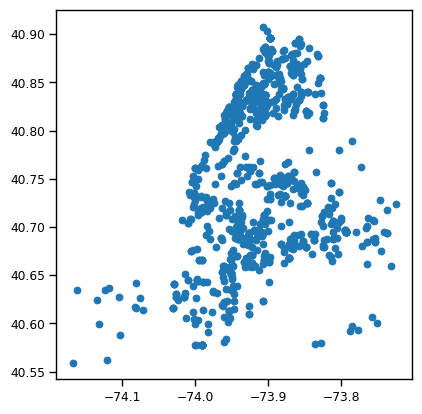

In [52]:
servicereq_geo.plot()

## 2.3 `offset` and `limit`
The issue with using this endpoint is that we are limited to 1000 rows per query. You will see the documentation refer to this as "pages" sometimes.


In [53]:
servicereq.shape

(1000, 33)

What to do? 

One way to get around this is to use the `limit` and `offset` parameters. From the SODA documentation: 

>The `$offset` parameter is most often used in conjunction with $limit to page through a dataset. The `$offset` is the number of records into a dataset that you want to start, indexed at 0. For example, to retrieve the “4th page” of records (records 151 - 200) where you are using `$limit` to page 50 records at a time, you’d ask for an `$offset` of 150.

In [54]:
servicereq_url_offset = "https://data.cityofnewyork.us/resource/erm2-nwe9.json?$limit=50&$offset=150&$where=created_date between '2023-02-01T0:00:00.000' and '2023-02-21T0:00:00.000' and complaint_type='Noise - Residential' and descriptor='Loud Music/Party'".replace(" ", "%20")
servicereq_offset = pd.read_json(servicereq_url_offset)

This is now 50 entries of the "4th page".

In [55]:
servicereq_offset

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,bbl
0,56856299,2023-02-20T16:09:11.000,2023-02-20T18:07:33.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11104,45-37 39 PLACE,...,QUEENS,1004933,209980,ONLINE,Unspecified,QUEENS,40.742999,-73.925360,"{'latitude': '40.742999012309355', 'longitude'...",NaN
1,56854620,2023-02-20T16:06:51.000,2023-02-20T16:49:24.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10026,150 MALCOLM X BOULEVARD,...,MANHATTAN,998378,231828,PHONE,Unspecified,MANHATTAN,40.802979,-73.948969,"{'latitude': '40.80297894530183', 'longitude':...",1.016010e+09
2,56854613,2023-02-20T15:54:09.000,2023-02-20T16:47:16.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11106,31-14 34 STREET,...,QUEENS,1005977,217128,ONLINE,Unspecified,QUEENS,40.762616,-73.921569,"{'latitude': '40.762615949551424', 'longitude'...",4.006230e+09
3,56850274,2023-02-20T15:53:54.000,2023-02-21T01:00:02.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10452,1350 SHAKESPEARE AVENUE,...,BRONX,1005761,245537,MOBILE,Unspecified,BRONX,40.840591,-73.922258,"{'latitude': '40.84059136898749', 'longitude':...",2.025200e+09
4,56853694,2023-02-20T15:33:04.000,2023-02-20T16:14:30.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10033,370 FORT WASHINGTON AVENUE,...,MANHATTAN,1000949,248059,ONLINE,Unspecified,MANHATTAN,40.847524,-73.939642,"{'latitude': '40.84752392884855', 'longitude':...",1.021420e+09
5,56854565,2023-02-20T15:30:21.000,2023-02-20T21:34:43.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11420,115-02 109 AVENUE,...,QUEENS,1032673,187549,ONLINE,Unspecified,QUEENS,40.681323,-73.825414,"{'latitude': '40.681322997257766', 'longitude'...",4.115960e+09
6,56856178,2023-02-20T15:17:07.000,2023-02-20T16:48:12.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10468,2353 DAVIDSON AVENUE,...,BRONX,1010849,252759,ONLINE,Unspecified,BRONX,40.860400,-73.903841,"{'latitude': '40.86039974871', 'longitude': '-...",2.031980e+09
7,56853642,2023-02-20T14:50:29.000,2023-02-20T16:05:41.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10031,610 WEST 141 STREET,...,MANHATTAN,997302,239524,ONLINE,Unspecified,MANHATTAN,40.824104,-73.952841,"{'latitude': '40.82410396969219', 'longitude':...",1.020880e+09
8,56850294,2023-02-20T14:49:00.000,2023-02-20T14:56:15.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11232,870 41 STREET,...,BROOKLYN,985071,174372,ONLINE,Unspecified,BROOKLYN,40.645287,-73.997042,"{'latitude': '40.645287460197544', 'longitude'...",3.009230e+09
9,56855978,2023-02-20T14:47:50.000,2023-02-21T06:34:52.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10460,1932 BRYANT AVENUE,...,BRONX,1016835,245328,ONLINE,Unspecified,BRONX,40.839984,-73.882236,"{'latitude': '40.83998380642961', 'longitude':...",2.030058e+09


So, to get all the data, what we can do is run a loop to change that offset amount iteratively. 

OR

If we are getting the data just once, we can use the filter function, accessible through the  "View Data" button on the dataset's home page. 

</figure>
<img src="https://www.dropbox.com/s/oz26ti7y164pm8r/Screen%20Shot%202023-02-19%20at%2012.35.21%20PM.png?dl=1" alt="drawing" width="1000" style="display: block; margin: 0 auto"/>
</figure>



### 2.3.1 A short review of loops

In [56]:
my_counter = np.arange(0,1000,50)
print(my_counter)

[  0  50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850
 900 950]


In [57]:
# The for loop will iterate through each value in the list
# The {} is a placeholder for the value in the list within a string
for i in my_counter:
    print("Current Counter is now at {}".format(i))

Current Counter is now at 0
Current Counter is now at 50
Current Counter is now at 100
Current Counter is now at 150
Current Counter is now at 200
Current Counter is now at 250
Current Counter is now at 300
Current Counter is now at 350
Current Counter is now at 400
Current Counter is now at 450
Current Counter is now at 500
Current Counter is now at 550
Current Counter is now at 600
Current Counter is now at 650
Current Counter is now at 700
Current Counter is now at 750
Current Counter is now at 800
Current Counter is now at 850
Current Counter is now at 900
Current Counter is now at 950


In [58]:
## reset i to 0
i = 0
## The while loop will continue to run until the condition is no longer true
while i < 1000:
    print("Current Counter is now at {}".format(i))
    
    ## This is an example of an incrementer
    ## An incrementer is a variable that is used to increment a value
    ## After each iteration, the value of i will increase by 50
    i = i + 50

Current Counter is now at 0
Current Counter is now at 50
Current Counter is now at 100
Current Counter is now at 150
Current Counter is now at 200
Current Counter is now at 250
Current Counter is now at 300
Current Counter is now at 350
Current Counter is now at 400
Current Counter is now at 450
Current Counter is now at 500
Current Counter is now at 550
Current Counter is now at 600
Current Counter is now at 650
Current Counter is now at 700
Current Counter is now at 750
Current Counter is now at 800
Current Counter is now at 850
Current Counter is now at 900
Current Counter is now at 950


In [60]:
for i in np.arange(0,100000,50):
    print("Current Counter is now at {}".format(i))
    i = i + 50

    if i >=1000:
        print("We are done")
        break

Current Counter is now at 0
Current Counter is now at 50
Current Counter is now at 100
Current Counter is now at 150
Current Counter is now at 200
Current Counter is now at 250
Current Counter is now at 300
Current Counter is now at 350
Current Counter is now at 400
Current Counter is now at 450
Current Counter is now at 500
Current Counter is now at 550
Current Counter is now at 600
Current Counter is now at 650
Current Counter is now at 700
Current Counter is now at 750
Current Counter is now at 800
Current Counter is now at 850
Current Counter is now at 900
Current Counter is now at 950
We are done


To programmatically run different queries, I just going to 

This might take a while to run and might not work at all given our 1000 an hour limit. :/

In [61]:
offset_list_smaller = np.arange(0,200,50)

In [62]:
offset_list_smaller

array([  0,  50, 100, 150])

In [63]:
## I actually don't know what the upper range is for my dataset, but I will just use 100,000
# offset_list = np.arange(0,100000,50)

# I'm actually going to use a smaller list for demo and not overloading the API
offset_list_smaller = np.arange(0,200,50)

list_of_dfs = []

for offset in offset_list_smaller:
    servicereq_url_offset = "https://data.cityofnewyork.us/resource/erm2-nwe9.json?$limit=50&$offset={}&$where=created_date between '2023-02-01T0:00:00.000' and '2023-02-19T0:00:00.000' and complaint_type='Noise - Residential' and descriptor='Loud Music/Party'".replace(" ", "%20").format(offset)
    servicereq_offset = pd.read_json(servicereq_url_offset)

    ## Here I am creating a list of dataframes by appending each dataframe to the list
    list_of_dfs.append(servicereq_offset)

In [65]:
# list_of_dfs

I now have a list of dataframes.

In [66]:
len(list_of_dfs)

4

In [67]:
## pd.concat will concatenate the dataframes in the list
## to create a single dataframe
servicereq_final = pd.concat(list_of_dfs)

In [69]:
servicereq_final.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location
0,56842009,2023-02-18T23:58:43.000,2023-02-19T00:31:51.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10303,250 VAN PELT AVENUE,...,5.012160e+09,STATEN ISLAND,941109,168759,ONLINE,Unspecified,STATEN ISLAND,40.629776,-74.155422,"{'latitude': '40.629775961552234', 'longitude'..."
1,56841733,2023-02-18T23:58:19.000,2023-02-19T00:19:42.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10002,63 PITT STREET,...,1.003430e+09,MANHATTAN,989049,200842,MOBILE,Unspecified,MANHATTAN,40.717940,-73.982688,"{'latitude': '40.717940324139875', 'longitude'..."
2,56839300,2023-02-18T23:57:53.000,2023-02-19T00:58:55.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11225,101 LINCOLN ROAD,...,3.013270e+09,BROOKLYN,995593,180120,MOBILE,Unspecified,BROOKLYN,40.661057,-73.959116,"{'latitude': '40.66105723901385', 'longitude':..."
3,56836282,2023-02-18T23:57:46.000,2023-02-19T00:22:05.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11230,1499 EAST 7 STREET,...,3.065890e+09,BROOKLYN,993377,162973,ONLINE,Unspecified,BROOKLYN,40.613995,-73.967126,"{'latitude': '40.6139949476275', 'longitude': ..."
4,56837511,2023-02-18T23:57:33.000,2023-02-19T08:12:59.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10457,2028 GRAND CONCOURSE,...,2.028130e+09,BRONX,1010776,249620,MOBILE,Unspecified,BRONX,40.851784,-73.904117,"{'latitude': '40.85178435645269', 'longitude':..."


If I were to really try and get all this data, I'd put a `sleep()` call from the library `time` to pause my code from running the next line for a certain amount of time. 

In [ ]:
import time

list_of_dfs = []

for offset in offset_list_smaller:
    servicereq_url_offset = "https://data.cityofnewyork.us/resource/erm2-nwe9.json?$limit=50&$offset={}&$where=created_date between '2023-02-01T0:00:00.000' and '2023-02-19T0:00:00.000' and complaint_type='Noise - Residential' and descriptor='Loud Music/Party'".replace(" ", "%20").format(offset)
    servicereq_offset = pd.read_json(servicereq_url_offset)

    ## Here I am creating a list of dataframes by appending each dataframe to the list
    list_of_dfs.append(servicereq_offset)
    
    ## I am adding a sleep timer to avoid overloading the API
    ## The sleep timer will pause the code for 10 seconds
    ## This gives me 10 seconds /run for each 50 records
    time.sleep(10)
    if servicereq_offset.shape[0] == 0:
        print("We are done")
        break

servicereq_final = pd.concat(list_of_dfs)

In [ ]:
servicereq_final.head()

Lastly! Don't think this means we can just get all the data at once. Each query we make "costs" the API provider resources. To ensure that everyone is able to use the API, the provider will limit your capacity to query. Here's their language on it:

>## Throttling and Application Tokens
>Hold on a second! Before you go storming off to make the next great open data app, you should understand how SODA handles throttling. You can make a certain number of requests without an application token, but they come from a shared pool and you’re eventually going to get cut off.
>
>If you want more requests, sign up for a Socrata account, then register for an application token and your application will be granted up to 1000 requests per rolling hour period. If you need even more than that, special exceptions are made by request. You can contact our support team here.

## Q.3 Querying and Concatenating 
- Using the [Film Permits](https://data.cityofnewyork.us/City-Government/Film-Permits/tg4x-b46p) dataset to retrieve two dataframes: 
    1. The **StartDateTime** should be after July 1, 2022
    2. The **StartDateTime** should be after July 1, 2022 & The **Category** should be `Television`. 
- Create a list of two dataframes with 50 rows per "page"
- Concatenate these two dataframes together into one dataframe
- Show the first 5 rows of the new dataframe.



Using the [Film Permits](https://data.cityofnewyork.us/City-Government/Film-Permits/tg4x-b46p) dataset to retrieve two dataframes: 
1. The **StartDateTime** should be after July 1, 2022
2. The **StartDateTime** should be after July 1, 2022 & The **Category** should be `Television`. 

In [ ]:
film_url1 = ## INSERT YOUR CODE HERE
film1 = pd.read_json(film_url1)

film_url2 = ## INSERT YOUR CODE HERE
film2 = pd.read_json(film_url2)

Concatenate these two dataframes together into one dataframe

In [ ]:
## INSERT YOUR CODE HERE

Show the first 5 rows of the new dataframe.


In [ ]:
## INSERT YOUR CODE HERE